<a href="https://colab.research.google.com/github/Lucky3210/AI_Learning/blob/main/Bikes_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression


 # Dataset
 The dataset contains count of public bicycles rented per hour in the Seoul Bike Sharing System, with corresponding weather data and holiday information.

UCI Machine Learning Repository[https://archive.ics.uci.edu/]. Irvine, CA,: University of California, School of Computing and Information Science.

Source: Data Source: https://data.seoul.go.kr/ SOUTH KOREA PUBLIC HOLIDAYS.

In [ ]:
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
datasetCols = ['bikeCount', 'hour', 'temp', 'humidity', 'wind', 'visibility', 'dewPointTemp', 'radiation', 'rain', 'snow', 'functional']
df.head()
# we added the encoding style, because of some characters not recognized by UTF-8
# like the degree symbol in our temperature. we either edit the file and get rid of it or add the encoding


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
# we would want to get rid some columns that are not necessary or that we don't need

df = pd.read_csv('SeoulBikeData.csv', encoding='latin1').drop(["Date", "Holiday", "Seasons"], axis=1) # axis means we should drop it from the columns
df.head()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [ ]:
# max(df['temp'])

In [ ]:
df.columns = datasetCols
# We want to convert the functional label from string datatype('yes') to an integer
# of either 1 or 0
df['functional'] = (df['functional'] == 'Yes').astype(int)

# we want to use the dataset where the hour is 12
df = df[df['hour'] == 12]

# we'll drop this column
df = df.drop(['hour'], axis=1)
df.head()
# we don't have the hour column in the dataset but the dataset is base on 12 hour

,bikeCount,temp,humidity,wind,visibility,dewPointTemp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


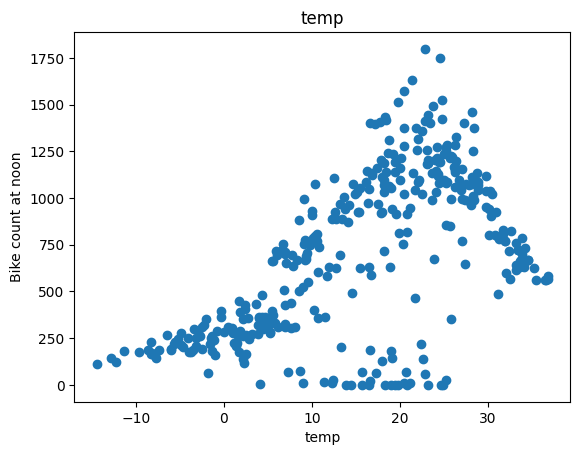

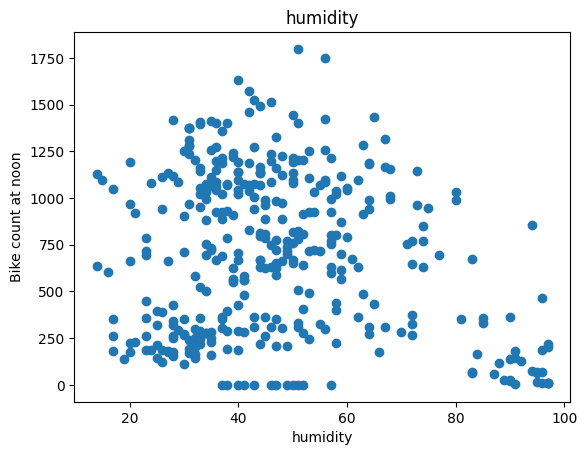

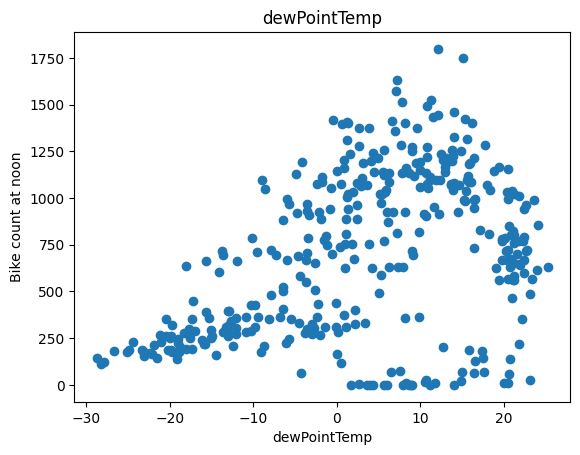

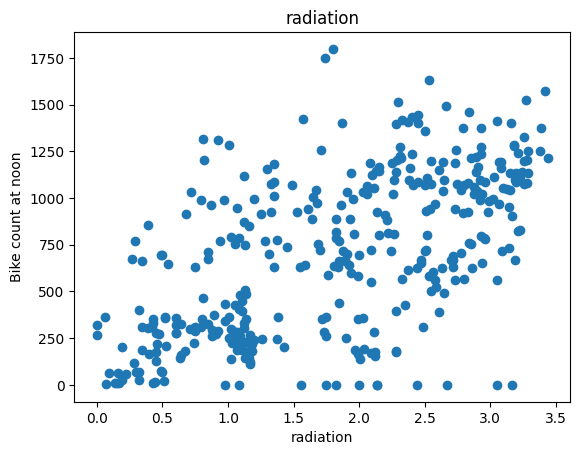

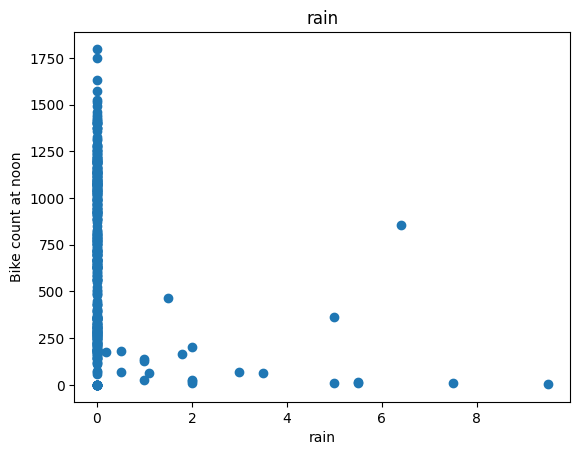

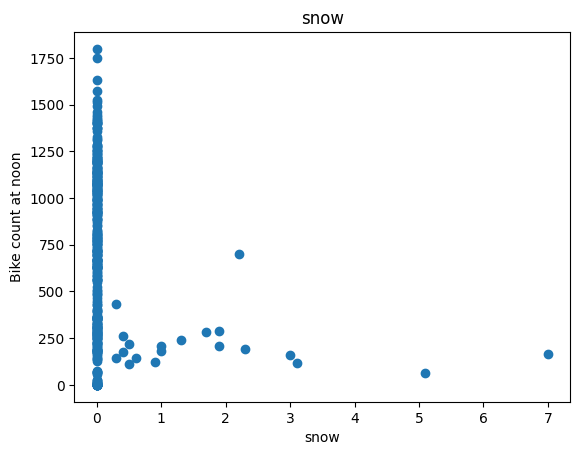

In [ ]:
# next we might have a plot for the feature labels relative to the output variable(bikeCount)

for label in df.columns[1:]:
  plt.scatter(df[label], df['bikeCount'])
  plt.title(label)
  plt.xlabel(label)
  plt.ylabel('Bike count at noon')
  plt.show()


In [ ]:
# we would get rid of the  labels that doesn't have a relaltionship with the bikes like wind, visibility and functional

df = df.drop(['wind', 'visibility', 'functional'], axis=1)
df.head()

,bikeCount,temp,humidity,dewPointTemp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# Train/Validation/Test

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.6 * len(df)), int(0.8 * len(df))])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
# as seen on the plot, we want to do a simple linear with specific labels like temp, rain etc.
# let's get those variables individually

def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe) # we get a copy of our dataframe
  if x_labels is None: # if x_labels is none
    X = dataframe[[column for column in dataframe.columns if column != y_label]].values
  else:

    if len(x_labels) == 1: # if we pass in a single x_label we want to get the label and reshape it to make it 2D
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else: # if we have a list of specific x_labels that we want to use
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y))
  return data, X, y




In [ ]:
_, X_train_temp, y_train_temp = get_xy(train, 'bikeCount', x_labels=['temp'])
_, X_val_temp, y_val_temp = get_xy(val, 'bikeCount', x_labels=['temp'])
_, X_test_temp, y_test_temp = get_xy(test, 'bikeCount', x_labels=['temp'])

In [ ]:
# creates a regressor

tempReg = LinearRegression()
tempReg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [ ]:
# we can print the coefficient and the y-intercept
print(tempReg.coef_, tempReg.intercept_)

# we can also score the model(the R square) using the test data
print(tempReg.score(X_test_temp, y_test_temp))
# our score is .3 which is better than 0 which would mean that there's absolutely no association
# the higher the number is, mean the higher the corelativity of the two variable.

[[22.29324142]] [355.64982747]
0.25131385452915733


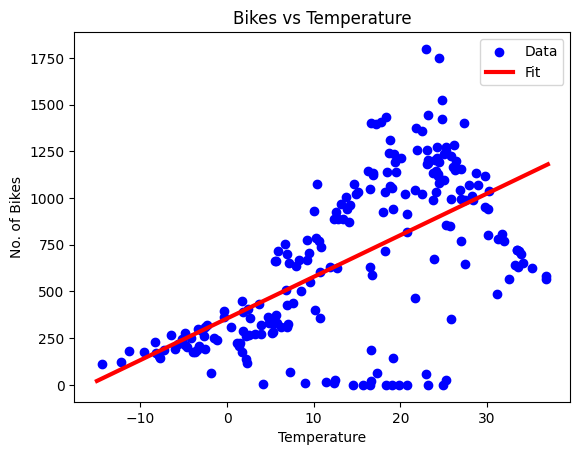

In [ ]:
# If we plotted it, it would look like this
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-15, 37, 100) # this provides the line base on the start (minimum temp(-15)) and the end(max(37)) of the interval. 100 rep the number of values to generate btw -15 and 37
plt.plot(x, tempReg.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title("Bikes vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("No. of Bikes")
plt.show()

# from the graph plotted, this is a simple linear reg. using temp as the only x variable.

In [ ]:

# Create a tensor with 10 evenly spaced values between -20 and 40
tensor = tf.linspace(-20, 40, 10)

print(tensor)

tf.Tensor(
[-20.         -13.33333333  -6.66666667   0.           6.66666667
  13.33333333  20.          26.66666667  33.33333333  40.        ], shape=(10,), dtype=float64)


# Multiple Linear Regression

In [ ]:
df.columns

Index(['bikeCount', 'temp', 'humidity', 'dewPointTemp', 'radiation', 'rain',
       'snow'],
      dtype='object')

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.6 * len(df)), int(0.8 * len(df))])
_, X_train_all, y_train_all = get_xy(train, 'bikeCount', x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, 'bikeCount', x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, 'bikeCount', x_labels=df.columns[1:])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
allReg = LinearRegression()
allReg.fit(X_train_all, y_train_all)

LinearRegression()

In [ ]:
allReg.score(X_test_all, y_test_all)
# our R square seems to improve which is good

0.5103771482656738

# Regression with Neural Net

In [ ]:
# we would start off by normaizing the data
tempNomalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
tempNomalizer.adapt(X_train_temp.reshape(-1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
tempNomalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
tempNomalizer.adapt(X_train_temp.reshape(-1))
temp_nn_model = tf.keras.Sequential([
    tempNomalizer,
    tf.keras.layers.Dense(units=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
temp_nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error'
)

In [ ]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    epochs=1000, verbose=0,
    validation_data=(X_val_temp, y_val_temp)
)

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

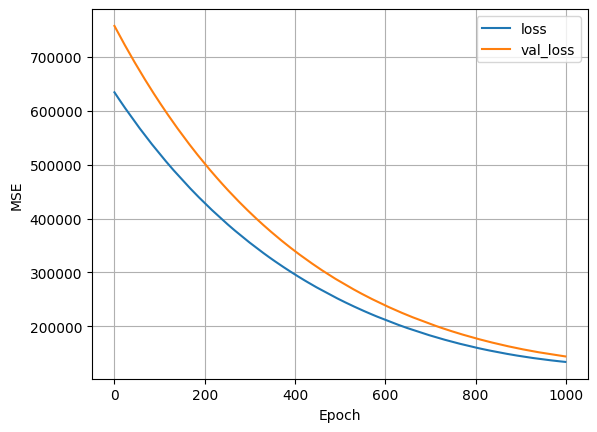

In [ ]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


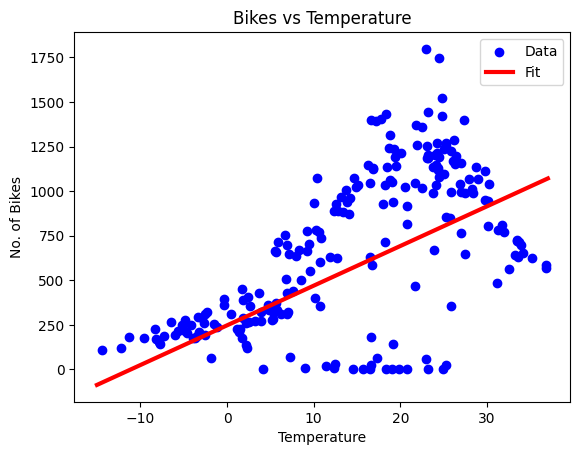

In [ ]:
# If we plotted it, it would look like this
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-15, 37, 100) # this provides the line base on the start (minimum temp(-15)) and the end(max(37)) of the interval. 100 rep the number of values to generate btw -15 and 37
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title("Bikes vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("No. of Bikes")
plt.show()

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

# Using a Neural Net

In [ ]:
nn_model = tf.keras.Sequential([
    tempNomalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
    ])

nn_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

In [ ]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    epochs=100, verbose=0,
    validation_data=(X_val_temp, y_val_temp)
)

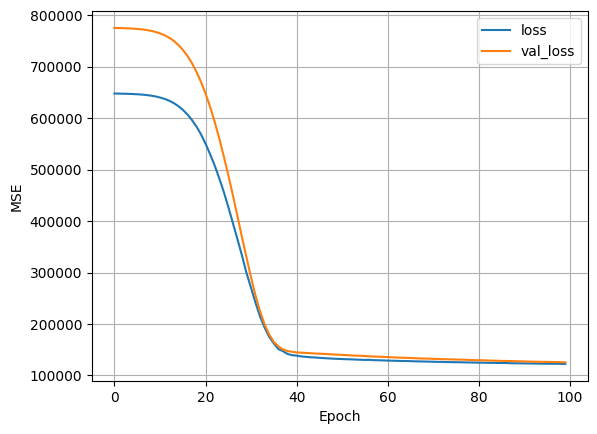

In [ ]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


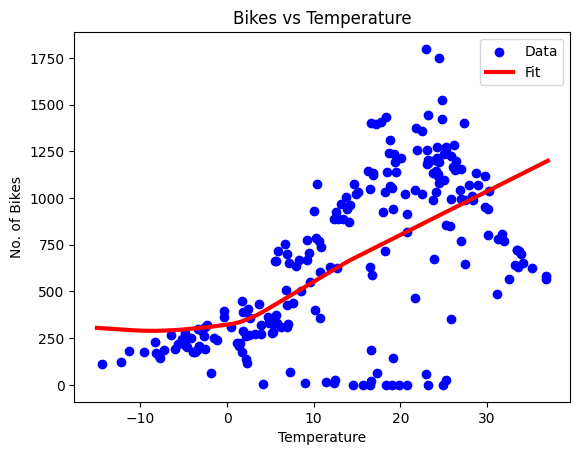

In [ ]:
# If we plotted it, it would look like this
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-15, 37, 100) # this provides the line base on the start (minimum temp(-15)) and the end(max(37)) of the interval. 100 rep the number of values to generate btw -15 and 37
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title("Bikes vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("No. of Bikes")
plt.show()